In [1]:
from scipy.io import wavfile
from scipy import signal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
from scipy.fftpack import fft, ifft
import IPython as IP
from sklearn.decomposition import FastICA
from scipy.stats import entropy
import math
import japanize_matplotlib

In [2]:
def player(sig):
    IP.display.display(IP.display.Audio(sig, rate=samplerate))

def writer(fname, data):
    wavfile.write(fname, samplerate, data.astype(np.int16))
    
def shift_vector(vec, shift):
    ans = 0 * np.array(vec)
    if shift > 0:
        ans[shift:] = vec[:-shift]
    elif shift < 0:
        ans[:shift] = vec[-shift:]
    else:
        ans = np.array(vec)
    return ans    
def zero_append(dat, pre, post):
    if pre < 0 or post < 0:
        print(f'[[WARNING]] pre={pre}, post={post}')
    return np.hstack([[0]*pre, dat, [0]*post])

In [3]:
# データ読み込み
rates,sources = [],[]
for name in ["source1", "source2"]:
    rate, source = wavfile.read(f'{name}.wav')
    rates.append(rate)
    sources.append(source)

print(rates)
samplerate = rates[0]

s = [x[:,0] for x in sources]
n = max([len(x) for x in s])
source1 = zero_append(s[0], 0, n-len(s[0]))
source2 = zero_append(s[1], 0, n-len(s[1]))

player(source1)
player(source2)

[44100, 44100]


In [4]:
mix1 = 0.55 * source1 + 0.45 * source2
mix2 = 0.45 * source1 + 0.55 * source2

In [5]:
player(mix1)
player(mix2)

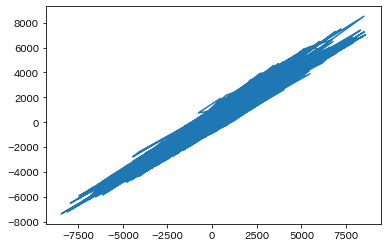

In [6]:
plt.plot(mix1, mix2)
plt.show()

In [12]:
# 基本的な関数
## 信号の白色化
def whiten(X):
    Y = np.array([x - np.mean(x) for x in X])
    R = (Y@Y.T) / Y.shape[1]
    w, E = LA.eig(R)
    V = np.diag([l**(-0.5) for l in w]) @ E.T
    return V @ Y

## 回転行列
def Rot(theta):
    c,s = math.cos(theta),math.sin(theta)
    return np.array([[c,-s],[s,c]])

## 連続系のエントロピーを離散系で近似して求める
def continuous_entropy(x):
    step = 1e-1             # 離散近似のステップ幅
    # アフィン変換 & int型への変換で離散系にする
    X = ((x - np.min(x)) / step).astype(np.int32)
    # 確率分布を計算する
    M = max(X)+1  # 配列のサイズを計算する
    P = [0 for i in range(M)]
    for i in X:
        P[i] += 1
    N = len(x)
    p = [Pi/N for Pi in P] # sum(p)=1で正規化
    return entropy(p) # 離散系としてエントロピーを計算して返す

## 2つの白色化された音源を分離したときのエントロピーの総和を返す
def calc_separated_entropy(theta, signals):
    R = Rot(theta)
    separated = R @ signals
    return sum([continuous_entropy(sig) for sig in separated])

# 独立成分分析を行う
def ica(sig1, sig2):
    # 白色化する
    whiten_sig = whiten(np.array([sig1, sig2]))
    
    # 分離する
    f = lambda theta: calc_separated_entropy(theta, whiten_sig) # エイリアスを貼る
    Theta = np.arange(0.0, math.pi, 0.02)
    H = [f(t) for t in Theta]
    theta = Theta[np.argmin(H)] #エントロピーを最小にするthetaを求める
    ans = Rot(theta) @ whiten_sig


    # 分離の様子を描画する
    ## 2つの信号の関係を描画する
    print("2つの信号の関係を描画する。")
    ptsize = 5 # plt.scatterのサイズを指定
    fig = plt.figure(figsize = (12,4))
    fig.add_subplot(131)
    plt.scatter(sig1, sig2, s=ptsize) # もとの信号
    plt.title("観測信号")
    fig.add_subplot(132)
    plt.scatter(whiten_sig[0], whiten_sig[1], s=ptsize) # 白色化
    plt.title("白色化信号")
    fig.add_subplot(133)
    plt.scatter(ans[0], ans[1], s=ptsize) # 分離
    plt.title("分離信号")
    plt.savefig("picture/signals.png")
    plt.show()
    
    ## 2つの信号の関係を別々の画像として描画する
    def sub_plot(s1, s2, title, name):
        fig = plt.figure(figsize = (4,4))
        fig.add_subplot(111)
        plt.scatter(s1, s2, s=ptsize) # もとの信号
        plt.title(title)
        plt.savefig(f'picture/{name}')
    sub_plot(sig1, sig2, "観測信号", "observed.png")
    sub_plot(whiten_sig[0], whiten_sig[1], "白色化信号", "whiten.png")
    sub_plot(ans[0], ans[1], "分離信号", "ans.png")
    
    ## エントロピーを描画する
    print("分離行列とエントロピーの関係を描画する。")
    fig = plt.figure(figsize = (12,6))
    fig.add_subplot(111)
    plt.plot(Theta, H)
    plt.title("エントロピーと分離方向の関係")
    plt.xlabel("方向[rad]")
    plt.ylabel("エントロピー")
    plt.savefig("picture/entropy.png")
    plt.show()

    
    ## 分離前の信号を描画する
    print("分離前後の信号を描画する。1段目が分離前の信号である。")
    fig = plt.figure(figsize = (12,4))
    fig.add_subplot(121)
    plt.plot(sig1)
    plt.title("混合信号1")
    fig.add_subplot(122)
    plt.plot(sig2)
    plt.title("混合信号2")
    plt.savefig("picture/mix.png")
    plt.show()



    # 分離後の信号を描画する
    print("分離後の信号を描画する。")
    fig = plt.figure(figsize = (12,4))
    fig.add_subplot(121)
    plt.plot(ans[0])
    plt.title("分離信号1")
    fig.add_subplot(122)
    plt.title("分離信号2")        
    plt.plot(ans[1])
    plt.savefig("picture/separated.png")
    plt.show()


    return ans

2つの信号の関係を描画する。


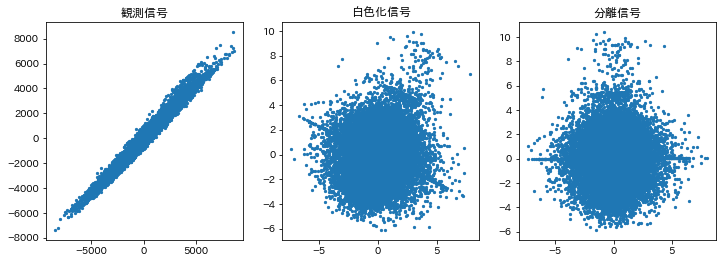

分離行列とエントロピーの関係を描画する。


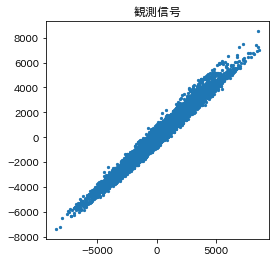

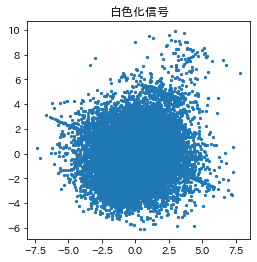

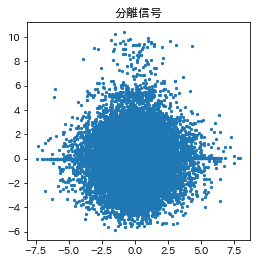

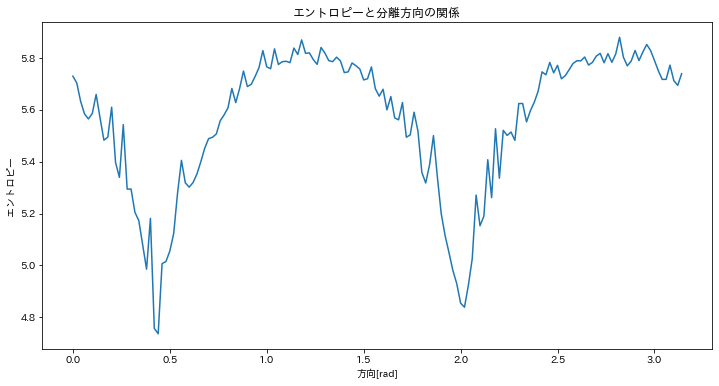

分離前後の信号を描画する。1段目が分離前の信号である。


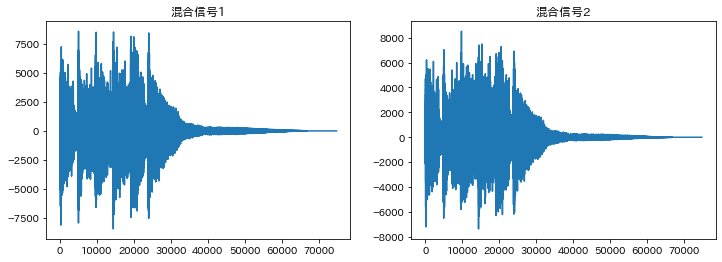

分離後の信号を描画する。


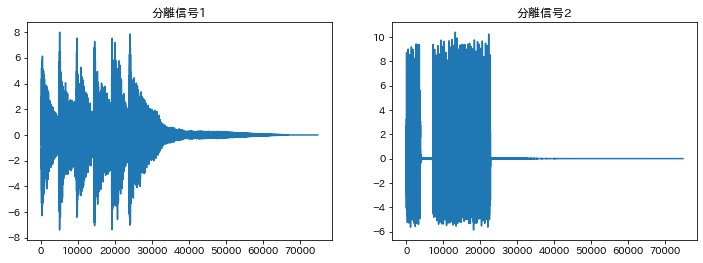

In [13]:
separated = ica(mix1, mix2)

In [14]:
player(separated[0])
player(separated[1])

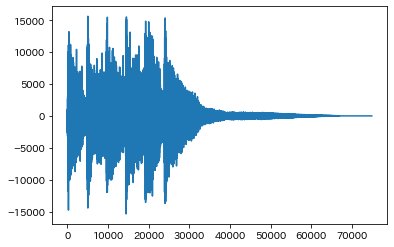

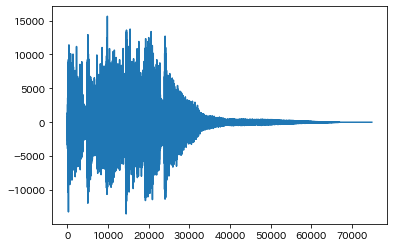

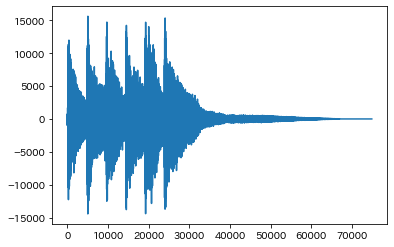

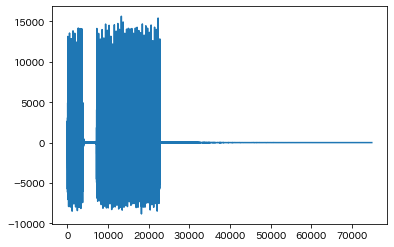

In [10]:
def write(fname, dat):
    r = np.max(source1) / np.max(dat)
    sound = r * dat
    plt.plot(sound)
    plt.show()
    writer(fname, r * dat)
write("mix1.wav", mix1)
write("mix2.wav", mix2)
write("separated1.wav", separated[0])
write("separated2.wav", separated[1])

In [11]:
print("waiwai")

waiwai
